## Linear regression - acat,hmp

### importing R into python environment

In [1]:
import os

import rpy2.robjects as ro


In [2]:
ro.r('version')

<rpy2.robjects.vectors.ListVector object at 0x0000026236B02BD0> [19]
R classes: ('simple.list',)
[StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe..., ..., StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe...]
  platform: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000002623AE19A50> [16]
R classes: ('character',)
['x86_64-w64-mingw32']
  arch: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000002623AE2CB50> [16]
R classes: ('character',)
['x86_64']
  os: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000002623AE1C250> [16]
R classes: ('character',)
['mingw32']
  crt: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000002623AE33350> [16]
R classes: ('character',)
['ucrt']
...
  status: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000002623AE33390> [16]
R classes: ('character',)
['87279']
  major: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000002623AE333D0> [16]
R classes: ('character',)
['R']
  minor: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000002623AE331D0> [16]
R classes: ('character',)
['R version 4.4.2 (2024-10-31 ucrt)']
  year: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000002623AE330D0> [16]
R classes: ('character',)
['Pile of Leaves']

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import t
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import cauchy

### conversion of dataframe between R and pandas(lib of python)

In [4]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# Activate automatic conversion between pandas DataFrame and R DataFrame
pandas2ri.activate()

### y(phenotype) = alpha*G + gamma*E +beta*(G*E)
### maf=minor allele freq

In [7]:
n_individuals= 1000
n_simulations=1000

maf=0.2
alpha = 0.3 
gamma=0.5
beta=0.2

In [8]:
def simulate_genotypes(num_individuals, freq_ref):
    genotypes=[]
    for i in range(num_individuals):
        p_aa = freq_ref ** 2
        p_Aa = 2 * freq_ref * (1 - freq_ref)
        p_AA = (1 - freq_ref) ** 2
        
        gen = random.choices([2, 1, 0], weights=[p_aa, p_Aa, p_AA])[0]
        genotypes.append(gen)
    return genotypes

In [9]:
def compute_p_value(X, y):
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    # Compute residual variance
    residuals = y - y_pred
    sigma_squared = np.var(residuals, ddof=X.shape[1])
    
    # Compute (X^T X)^-1
    X_transpose_X_inv = np.linalg.inv(X.T @ X)
    
    # Standard error for interaction coefficient
    interaction_idx = -1  # Interaction is the last column
    SE_interaction = np.sqrt(sigma_squared * np.diag(X_transpose_X_inv)[interaction_idx])
    
    # Compute t-statistic and p-value
    interaction_coef = model.coef_[interaction_idx]
    t_stat = interaction_coef / SE_interaction
    dof = n_individuals - X.shape[1]
    p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=dof))
    
    return p_value

In [17]:
def acat(pvals, weights=None):
    pvals = np.array(pvals)
    if np.any(pvals <= 0) or np.any(pvals >= 1):
        raise ValueError("P-values must be between 0 and 1 (exclusive).")

    if weights is None:
        weights = np.ones(len(pvals))  # Equal weights if not provided

    weights = np.array(weights) / np.sum(weights)  # Normalize weights
    cauchy_transformed = np.tan(np.pi * (0.5 - pvals))  # Cauchy transformation

    acat_statistic = np.sum(weights * cauchy_transformed)  # Weighted sum
    p_acat = 1 - cauchy.cdf(acat_statistic)  # Convert back to p-value

    return p_acat

# def compute_statistics(X, y, alpha=0.05):
    # Add an intercept term if not already included
    X_with_const = sm.add_constant(X)
    
    # Fit the OLS model
    model = sm.OLS(y, X_with_const).fit()
    
    # Get p-values, standard errors, and coefficients from the model
    p_values = model.pvalues
    standard_errors = model.bse
    coefficients = model.params
    
    # Assuming the interaction term is the last predictor (excluding the constant)
    # Its index will be -1 in the series p_values after the constant.
    interaction_p_value = p_values.iloc[-1]
    interaction_std_error = standard_errors.iloc[-1]
    
    # Determine significance at the given alpha level
    is_significant = interaction_p_value < alpha
    
    # Optionally print the model summary for full details
    print(model.summary())
    
    return {
        "model": model,
        "p_values": p_values,
        "standard_errors": standard_errors,
        "coefficients": coefficients,
        "interaction_significant": is_significant,
        "interaction_p_value": interaction_p_value,
        "interaction_std_error": interaction_std_error
    }

### Phenotype using Additive model 

In [ ]:
power_results_add = {"Additive": 0, "Dominant": 0, "Recessive": 0}

p_values_add = []
p_values_dom = []
p_values_rec = []

for _ in range(n_simulations):
    # Generate random data
    df=pd.DataFrame()
    df['genotypes'] = simulate_genotypes(n_individuals,maf)
    df['exposure'] = np.random.binomial(1, 0.6, n_individuals)
    
    # True phenotype (Additive Model)
    df['phenotype_additive'] = (
        alpha * df['genotypes']  + 
        gamma * df['exposure'] + 
        beta * (df['genotypes']  * df['exposure']) + 
        np.random.normal(0, 1, n_individuals)
    )
    df['genotypes_dom'] = (df['genotypes'] > 0).astype(int)
    df['genotypes_rec'] = (df['genotypes'] == 2).astype(int)
    
    
    # Additive Coding Model
    X_additive = np.column_stack((np.ones(n_individuals), df['genotypes'], df['exposure'], df['genotypes'] * df['exposure']))
    p_value_additive = compute_p_value(X_additive,df['phenotype_additive']) 
    p_values_add.append(p_value_additive)
    
    # Dominant Coding Model (aa/Aa=1, AA=0)
    X_dominant = np.column_stack((np.ones(n_individuals), df['genotypes_dom'], df['exposure'], df['genotypes_dom'] * df['exposure']))
    
    p_value_dominant = compute_p_value(X_dominant,df['phenotype_additive'])  
    p_values_dom.append(p_value_dominant)
    
    # Recessive Coding Model (aa=1, Aa/AA=0)
    X_recessive = np.column_stack((np.ones(n_individuals), df['genotypes_rec'], df['exposure'], df['genotypes_rec'] * df['exposure']))
    
    p_value_recessive = compute_p_value(X_recessive,df['phenotype_additive'])
    p_values_rec.append(p_value_recessive)
    
    # Count how many times the p-value is < 0.05 (Statistical Power)
    power_results_add["Additive"] += (p_value_additive < 0.05)
    power_results_add["Dominant"] += (p_value_dominant < 0.05)
    power_results_add["Recessive"] += (p_value_recessive < 0.05)

# Convert counts to power (proportion)
for key in power_results_add:
    power_results_add[key] /= n_simulations

# Convert to DataFrame for plotting
df_power_add = pd.DataFrame(list(power_results_add.items()), columns=["Coding Model", "Power"])
pvalues = pd.DataFrame({'p_values_additive':p_values_add , 'p_values_dominant':p_values_dom, 'p_values_recessive':p_values_rec })

ro.r('''
    library(harmonicmeanp)
    hmp_calc <- function(p_values) {
        p_values <- as.matrix(p_values)  # Ensure matrix format
        hmp_values <- apply(p_values, 1, function(x) p.hmp(x, w = NULL))  # Compute HMP row-wise
        return(as.vector(hmp_values))  # Ensure it returns a vector
    }
''')
hmp_calc = ro.globalenv['hmp_calc']

r_matrix = ro.conversion.py2rpy(pvalues)    
hmp_value = list(hmp_calc(r_matrix))
pvalues['hmp']= hmp_value

hmp1 = 0 
for i in pvalues['hmp']:
    if i < 0.05:
        hmp1+=1
hmp1= hmp1/n_individuals
df_power_add.loc[len(df_power_add)] = ["HMP", hmp1]
pvalues['acat'] = pvalues.apply(lambda row: acat(row.values), axis=1)
acat_power = np.mean(pvalues['acat'] < 0.05)
df_power_add.loc[len(df_power_add)] = ["ACAT", acat_power]

 # Print power values
print("Power Estimates:")

print(df_power_add)


R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



Power Estimates:
  Coding Model  Power
0     Additive  0.045
1     Dominant  0.053
2    Recessive  0.049
3          HMP  0.039
4         ACAT  0.048


### Phenotype using Dominant model 

In [11]:
power_results_dom = {"Additive": 0, "Dominant": 0, "Recessive": 0}

p_values_add = []
p_values_dom = []
p_values_rec = []

for _ in range(n_simulations):
    df['phenotype_dominant'] = (
        alpha * df['genotypes_dom']  + 
        gamma * df['exposure'] + 
        beta * (df['genotypes_dom']  * df['exposure']) + 
        np.random.normal(0, 1, n_individuals)
    )
    # Additive Coding Model
    p_value_additive = compute_p_value(X_additive, df['phenotype_dominant'])
    
    # Dominant Coding Model (AA/Aa=1, aa=0)
    p_value_dominant = compute_p_value(X_dominant, df['phenotype_dominant'])
    
    # Recessive Coding Model (AA=1, Aa/aa=0)
    p_value_recessive = compute_p_value(X_recessive, df['phenotype_dominant'])

    p_values_add.append(p_value_additive)
    p_values_dom.append(p_value_dominant)
    p_values_rec.append(p_value_recessive)
    # Count how many times the p-value is < 0.05 (Statistical Power)
    power_results_dom["Additive"] += (p_value_additive < 0.05)
    power_results_dom["Dominant"] += (p_value_dominant < 0.05)
    power_results_dom["Recessive"] += (p_value_recessive < 0.05)
for key in power_results_dom:
    power_results_dom[key] /= n_simulations

# Convert to DataFrame for plotting
df_power_dom = pd.DataFrame(list(power_results_dom.items()), columns=["Coding Model", "Power"])
pvalues = pd.DataFrame({'p_values_additive':p_values_add , 'p_values_dominant':p_values_dom, 'p_values_recessive':p_values_rec })

ro.r('''
    library(harmonicmeanp)
    hmp_calc <- function(p_values) {
        p_values <- as.matrix(p_values)  # Ensure matrix format
        hmp_values <- apply(p_values, 1, function(x) p.hmp(x, w = NULL))  # Compute HMP row-wise
        return(as.vector(hmp_values))  # Ensure it returns a vector
    }
''')
hmp_calc = ro.globalenv['hmp_calc']

r_matrix = ro.conversion.py2rpy(pvalues)    
hmp_value = list(hmp_calc(r_matrix))
pvalues['hmp']= hmp_value

hmp1 = 0 
for i in pvalues['hmp']:
    if i < 0.05:
        hmp1+=1
hmp1= hmp1/n_simulations
df_power_dom.loc[len(df_power_dom)] = ["HMP", hmp1]


print("Power Estimates:")
print(df_power_dom)

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



Power Estimates:
  Coding Model  Power
0     Additive  0.290
1     Dominant  0.305
2    Recessive  0.069
3          HMP  0.246


### Phenotype using Recessive model 

In [12]:
power_results_rec = {"Additive": 0, "Dominant": 0, "Recessive": 0}

p_values_add = []
p_values_dom = []
p_values_rec = []

for _ in range(n_simulations):

    # True phenotype (Recessive Model)
    df['phenotype_recessive'] = (
        alpha * df['genotypes_rec']  + 
        gamma * df['exposure'] + 
        beta * (df['genotypes_rec']  * df['exposure']) + 
        np.random.normal(0, 1, n_individuals)
    )
    # Additive Coding Model
    p_value_additive = compute_p_value(X_additive, df['phenotype_recessive'])
    
    # Dominant Coding Model (AA/Aa=1, aa=0)
    p_value_dominant = compute_p_value(X_dominant, df['phenotype_recessive'])
    
    # Recessive Coding Model (AA=1, Aa/aa=0)
    p_value_recessive = compute_p_value(X_recessive, df['phenotype_recessive'])

    p_values_add.append(p_value_additive)
    p_values_dom.append(p_value_dominant)
    p_values_rec.append(p_value_recessive)
    # Count how many times the p-value is < 0.05 (Statistical Power)
    power_results_rec["Additive"] += (p_value_additive < 0.05)
    power_results_rec["Dominant"] += (p_value_dominant < 0.05)
    power_results_rec["Recessive"] += (p_value_recessive < 0.05)
    
for key in power_results_rec:
    power_results_rec[key] /= n_simulations

# Convert to DataFrame for plotting
df_power_rec = pd.DataFrame(list(power_results_rec.items()), columns=["Coding Model", "Power"])
pvalues = pd.DataFrame({'p_values_additive':p_values_add , 'p_values_dominant':p_values_dom, 'p_values_recessive':p_values_rec })

ro.r('''
    library(harmonicmeanp)
    hmp_calc <- function(p_values) {
        p_values <- as.matrix(p_values)  # Ensure matrix format
        hmp_values <- apply(p_values, 1, function(x) p.hmp(x, w = NULL))  # Compute HMP row-wise
        return(as.vector(hmp_values))  # Ensure it returns a vector
    }
''')
hmp_calc = ro.globalenv['hmp_calc']

r_matrix = ro.conversion.py2rpy(pvalues)    
hmp_value = list(hmp_calc(r_matrix))
pvalues['hmp']= hmp_value

hmp1 = 0 
for i in pvalues['hmp']:
    if i < 0.05:
        hmp1+=1
hmp1= hmp1/n_simulations
df_power_rec.loc[len(df_power_rec)] = ["HMP", hmp1]


print("Power Estimates:")
print(df_power_rec)

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



Power Estimates:
  Coding Model  Power
0     Additive  0.071
1     Dominant  0.066
2    Recessive  0.100
3          HMP  0.076


### all 3 models

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8212\1531567847.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coding Model', y='Power', data=datasets[i], palette="Set2", ax=ax)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8212\1531567847.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coding Model', y='Power', data=datasets[i], palette="Set2", ax=ax)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8212\1531567847.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coding Model', y='Power', data=datasets[i], palette="Set2", ax=ax)


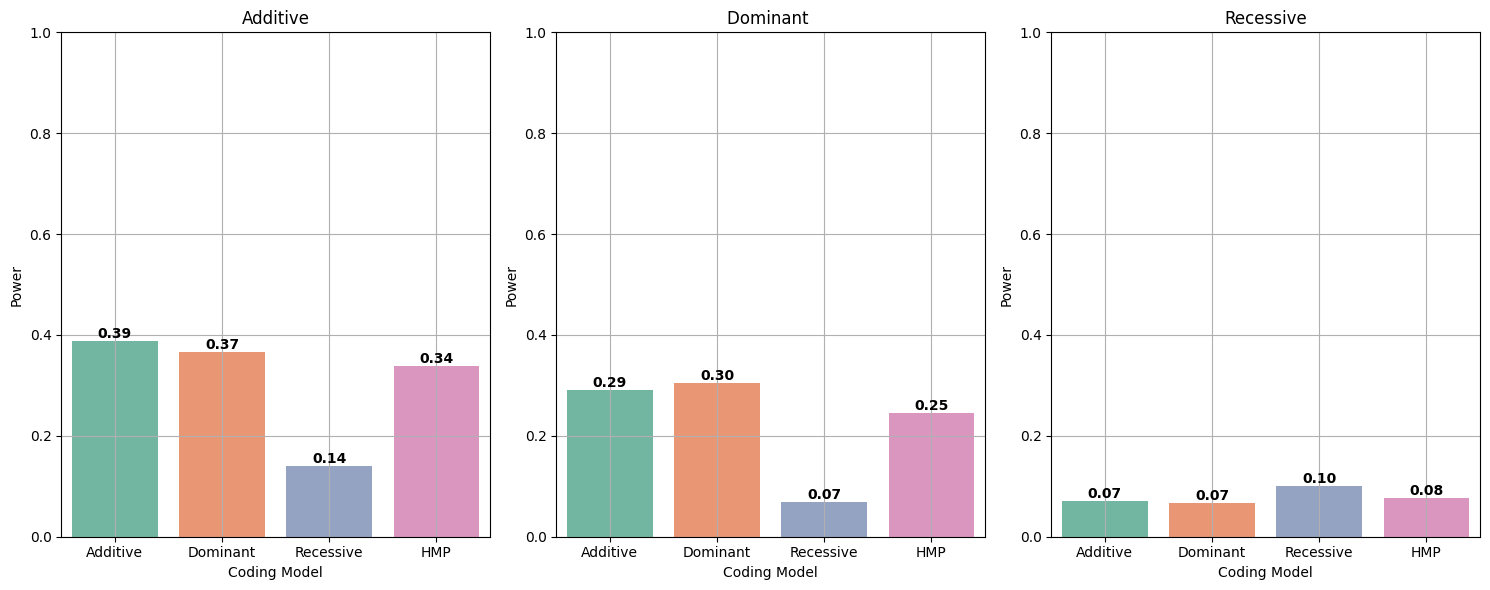

Power Estimates:
Additive phenotype:
  Coding Model  Power
0     Additive  0.388
1     Dominant  0.367
2    Recessive  0.141
3          HMP  0.338
Dominant phenotype
  Coding Model  Power
0     Additive  0.290
1     Dominant  0.305
2    Recessive  0.069
3          HMP  0.246
Recessive phenotype
  Coding Model  Power
0     Additive  0.071
1     Dominant  0.066
2    Recessive  0.100
3          HMP  0.076


In [13]:
# Create a figure with three subplots arranged in one row
fig, axes = plt.subplots(1, 3, figsize=(15,6))  # 2 rows, 3 columns

# Example datasets (Replace with your actual data)
datasets = [df_power_add, df_power_dom, df_power_rec]  
 
titles = ["Additive", "Dominant ", "Recessive"]

# Loop through subplots and create plots
for i, ax in enumerate(axes.flat):  # Flatten 2D axes array to iterate easily
    sns.barplot(x='Coding Model', y='Power', data=datasets[i], palette="Set2", ax=ax)
    ax.set_ylim(0, 1)  # Set y-axis limit
    ax.set_title(titles[i])
    ax.grid(True)  # Add grid

    # Annotate bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

print("Power Estimates:")

print("Additive phenotype:")
print(df_power_add)
print("Dominant phenotype")
print(df_power_dom)
print("Recessive phenotype")
print(df_power_rec)

### for a range of alpha,beta values

In [1]:
import rpy2.robjects as ro

# Define HMP and ACAT functions in R
ro.r('''
    library(harmonicmeanp)
    library(ACAT)

    hmp_calc <- function(p_values) {
        p_values <- as.matrix(p_values)
        hmp_values <- apply(p_values, 1, function(x) p.hmp(x, w = NULL))
        return(as.vector(hmp_values))
    }

    acat_calc <- function(p_values) {
        return(ACAT(p_values))
    }
''')

# Get R functions into Python
# hmp_calc = ro.globalenv['hmp_calc']
# acat_calc = ro.globalenv['acat_calc']

R[write to console]: Loading required package: FMStable

R[write to console]: Error in library(ACAT) : there is no package called 'ACAT'

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package 'harmonicmeanp' was built under R version 4.4.3 



RRuntimeError: Error in library(ACAT) : there is no package called 'ACAT'


In [15]:
alpha_values = [0.1, 0.2, 0.3]
beta_values = [0, 0.2, 0.4]

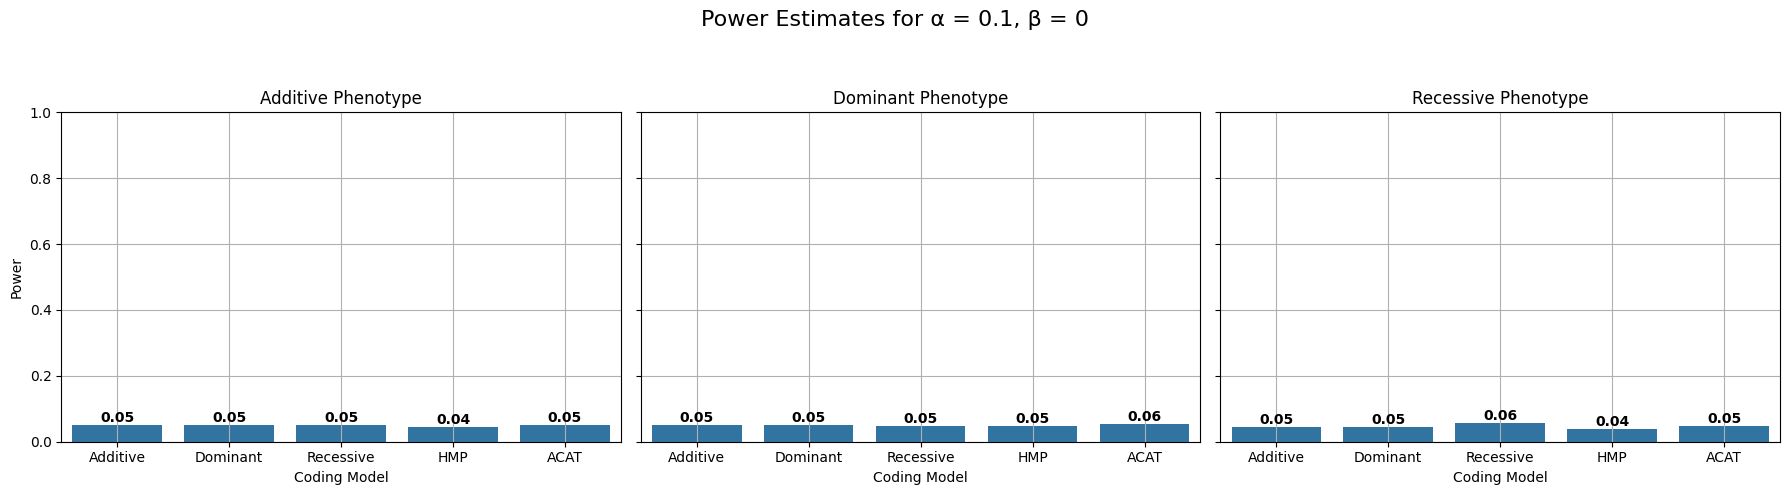

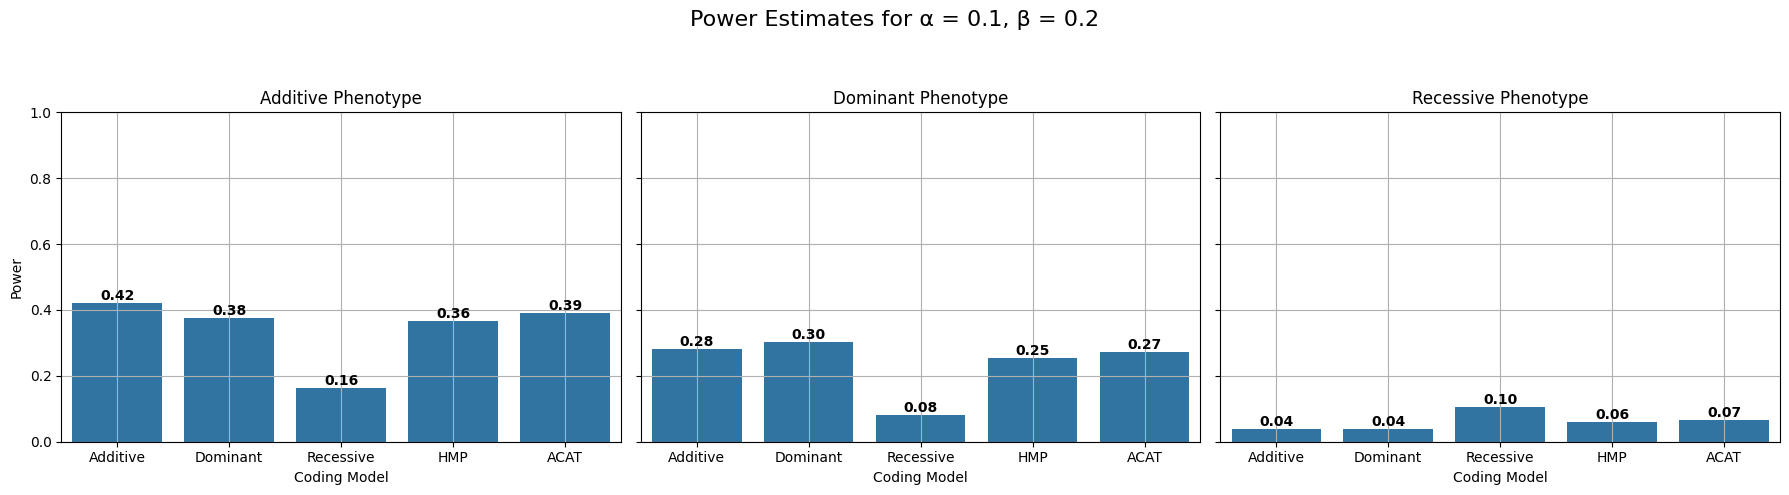

In [ ]:
# Loop over each combination of α and β
for alpha in alpha_values:
    for beta in beta_values:
        # --- Initialize dictionaries to accumulate power for each phenotype type ---
        power_results_add = {"Additive": 0, "Dominant": 0, "Recessive": 0, "HMP": 0, 'ACAT': 0}
        power_results_dom = {"Additive": 0, "Dominant": 0, "Recessive": 0, "HMP": 0, 'ACAT': 0}
        power_results_rec = {"Additive": 0, "Dominant": 0, "Recessive": 0, "HMP": 0, 'ACAT': 0}
        
        # --- Simulation for Additive Phenotype ---
        for _ in range(n_simulations):
            df = pd.DataFrame()
            df['genotypes'] = simulate_genotypes(n_individuals, maf)
            df['exposure'] = np.random.binomial(1, 0.6, n_individuals)
            # Create alternative codings
            df['genotypes_dom'] = (df['genotypes'] > 0).astype(int)
            df['genotypes_rec'] = (df['genotypes'] == 2).astype(int)
            
            # Generate phenotype using additive model (raw genotype)
            df['phenotype'] = (alpha * df['genotypes'] +
                               gamma * df['exposure'] +
                               beta * (df['genotypes'] * df['exposure']) +
                               np.random.normal(0, 1, n_individuals))
            
            # --- Fit OLS models for three genotype codings ---
            X_add = np.column_stack((np.ones(n_individuals),
                                      df['genotypes'],
                                      df['exposure'],
                                      df['genotypes'] * df['exposure']))
            
            p_val_add = compute_p_value(X_add,df['phenotype'])
            
            X_dom = np.column_stack((np.ones(n_individuals),
                                      df['genotypes_dom'],
                                      df['exposure'],
                                      df['genotypes_dom'] * df['exposure']))
           
            p_val_dom = compute_p_value(X_dom,df['phenotype'])
            
            X_rec = np.column_stack((np.ones(n_individuals),
                                      df['genotypes_rec'],
                                      df['exposure'],
                                      df['genotypes_rec'] * df['exposure']))
            
            p_val_rec = compute_p_value(X_rec,df['phenotype'])
            
            power_results_add["Additive"] += (p_val_add < 0.05)
            power_results_add["Dominant"] += (p_val_dom < 0.05)
            power_results_add["Recessive"] += (p_val_rec < 0.05)
            
            # Compute HMP using the R function
            pvals_arr = np.array([[p_val_add, p_val_dom, p_val_rec]])
            r_matrix = ro.conversion.py2rpy(pvals_arr)
            hmp_val = list(hmp_calc(r_matrix))[0]
            power_results_add["HMP"] += (hmp_val < 0.05)

            acat_val = acat([p_val_add, p_val_dom, p_val_rec])
            power_results_add["ACAT"] += (acat_val < 0.05)
            
        # --- Simulation for Dominant Phenotype ---
        for _ in range(n_simulations):
            df = pd.DataFrame()
            df['genotypes'] = simulate_genotypes(n_individuals, maf)
            df['exposure'] = np.random.binomial(1, 0.6, n_individuals)
            df['genotypes_dom'] = (df['genotypes'] > 0).astype(int)
            df['genotypes_rec'] = (df['genotypes'] == 2).astype(int)
            
            # Generate phenotype using dominant model (using genotypes_dom)
            df['phenotype'] = (alpha * df['genotypes_dom'] +
                               gamma * df['exposure'] +
                               beta * (df['genotypes_dom'] * df['exposure']) +
                               np.random.normal(0, 1, n_individuals))
            
            X_add = np.column_stack((np.ones(n_individuals),
                                      df['genotypes'],
                                      df['exposure'],
                                      df['genotypes'] * df['exposure']))
            
            p_val_add = compute_p_value(X_add,df['phenotype'])
            
            X_dom = np.column_stack((np.ones(n_individuals),
                                      df['genotypes_dom'],
                                      df['exposure'],
                                      df['genotypes_dom'] * df['exposure']))
            
            p_val_dom = compute_p_value(X_dom,df['phenotype'])
            
            X_rec = np.column_stack((np.ones(n_individuals),
                                      df['genotypes_rec'],
                                      df['exposure'],
                                      df['genotypes_rec'] * df['exposure']))
            
            p_val_rec = compute_p_value(X_rec,df['phenotype'])
            
            power_results_dom["Additive"] += (p_val_add < 0.05)
            power_results_dom["Dominant"] += (p_val_dom < 0.05)
            power_results_dom["Recessive"] += (p_val_rec < 0.05)
            
            pvals_arr = np.array([[p_val_add, p_val_dom, p_val_rec]])
            r_matrix = ro.conversion.py2rpy(pvals_arr)
            hmp_val = list(hmp_calc(r_matrix))[0]
            power_results_dom["HMP"] += (hmp_val < 0.05)

            acat_val = acat([p_val_add, p_val_dom, p_val_rec])
            power_results_dom["ACAT"] += (acat_val < 0.05)
        
        # --- Simulation for Recessive Phenotype ---
        for _ in range(n_simulations):
            df = pd.DataFrame()
            df['genotypes'] = simulate_genotypes(n_individuals, maf)
            df['exposure'] = np.random.binomial(1, 0.6, n_individuals)
            df['genotypes_dom'] = (df['genotypes'] > 0).astype(int)
            df['genotypes_rec'] = (df['genotypes'] == 2).astype(int)
            
            # Generate phenotype using recessive model (using genotypes_rec)
            df['phenotype'] = (alpha * df['genotypes_rec'] +
                               gamma * df['exposure'] +
                               beta * (df['genotypes_rec'] * df['exposure']) +
                               np.random.normal(0, 1, n_individuals))
            
            X_add = np.column_stack((np.ones(n_individuals),
                                      df['genotypes'],
                                      df['exposure'],
                                      df['genotypes'] * df['exposure']))
            
            p_val_add = compute_p_value(X_rec,df['phenotype'])
            
            X_dom = np.column_stack((np.ones(n_individuals),
                                      df['genotypes_dom'],
                                      df['exposure'],
                                      df['genotypes_dom'] * df['exposure']))
            
            p_val_dom = compute_p_value(X_rec,df['phenotype'])
            
            X_rec = np.column_stack((np.ones(n_individuals),
                                      df['genotypes_rec'],
                                      df['exposure'],
                                      df['genotypes_rec'] * df['exposure']))
            
            p_val_rec = compute_p_value(X_rec,df['phenotype'])
            
            power_results_rec["Additive"] += (p_val_add < 0.05)
            power_results_rec["Dominant"] += (p_val_dom < 0.05)
            power_results_rec["Recessive"] += (p_val_rec < 0.05)
            
            pvals_arr = np.array([[p_val_add, p_val_dom, p_val_rec]])
            r_matrix = ro.conversion.py2rpy(pvals_arr)
            hmp_val = list(hmp_calc(r_matrix))[0]
            power_results_rec["HMP"] += (hmp_val < 0.05)

            acat_val = acat([p_val_add, p_val_dom, p_val_rec])
            power_results_rec["ACAT"] += (acat_val < 0.05)
            
        
        # Convert counts to proportions for each phenotype type
        for key in power_results_add:
            power_results_add[key] /= n_simulations
        for key in power_results_dom:
            power_results_dom[key] /= n_simulations
        for key in power_results_rec:
            power_results_rec[key] /= n_simulations
        
        # --- Plot the three subplots for the current (α, β) combination ---
        fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
        fig.suptitle(f"Power Estimates for α = {alpha}, β = {beta}", fontsize=16)

        phenotypes = ["Additive Phenotype", "Dominant Phenotype", "Recessive Phenotype"]
        power_results = [power_results_add, power_results_dom, power_results_rec]

        for ax, phenotype, power_result in zip(axes, phenotypes, power_results):
            df_plot = pd.DataFrame(list(power_result.items()), columns=["Coding Model", "Power"])
            sns.barplot(x="Coding Model", y="Power", data=df_plot, ax=ax)
            
            ax.set_title(phenotype)
            ax.set_ylim(0, 1)
            ax.grid(True)
            
            # Annotate each bar
            for p in ax.patches:
                ax.annotate(f"{p.get_height():.2f}",  
                            (p.get_x() + p.get_width() / 2, p.get_height()),  # Position
                            ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

        plt.tight_layout(rect=[0, 0, 1, 0.92])
        plt.show()
     
        # # Additive Phenotype
        # df_add_plot = pd.DataFrame(list(power_results_add.items()), columns=["Coding Model", "Power"])
        # sns.barplot(x="Coding Model", y="Power", data=df_add_plot, palette="Set2", ax=axes[0])
        # axes[0].set_title("Additive Phenotype")
        # axes[0].set_ylim(0, 1)
        # axes[0].grid(True)
        
        # # Dominant Phenotype
        # df_dom_plot = pd.DataFrame(list(power_results_dom.items()), columns=["Coding Model", "Power"])
        # sns.barplot(x="Coding Model", y="Power", data=df_dom_plot, palette="Set2", ax=axes[1])
        # axes[1].set_title("Dominant Phenotype")
        # axes[1].set_ylim(0, 1)
        # axes[1].grid(True)
        
        # # Recessive Phenotype
        # df_rec_plot = pd.DataFrame(list(power_results_rec.items()), columns=["Coding Model", "Power"])
        # sns.barplot(x="Coding Model", y="Power", data=df_rec_plot, palette="Set2", ax=axes[2])
        # axes[2].set_title("Recessive Phenotype")
        # axes[2].set_ylim(0, 1)
        # axes[2].grid(True)
        
        
        
        